# Data Extraction and Scraping

For this section I installed the neccessary packages needed for this implementation. 
- Vadersentiment module was used for the vader sentiment analysis
- The Praw library was used for extracting the data from reddit api
- The selenium and chromium-chrome driver was to gives us the abiity to implement quoras endless scroll in code, code automatically scrolls to the end of each page of quora link. Selenium opens up the page and automatially implements endless scroll to end of the page.
- Beautiful soup which is a web scraping tool was used for extracting the data from a web page based on html classes,in this case we look for the css class that captures each answer on quora and extract all the elements that has this particular class in them. 
- re is a regular expression library used for removing the stop words in the corpus.


In [ ]:
# Install Required Package
# Install Vader
!pip install vaderSentiment
# Install Praw
!pip install praw
# install chromium, its driver, and selenium
!apt update
!apt install chromium-chromedriver
!pip install selenium

     |████████████████████████████████| 127 kB 13.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.9
    Uninstalling urllib3-1.26.9:
      Successfully uninstalled urllib3-1.26.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.1.5 requires urllib3[secure,socks]~=1.26, but you have urllib3 1.25.11 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repo

In [ ]:
import re
import urllib
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import seaborn as sns
import ssl
import time
from urllib.request import Request, urlopen
# Get full column
pd.set_option('display.max_colwidth', None)
sns.set_context("poster")

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


This was implemented to ignore ssl certificate errors the code might  face while scraping the websites.

In [ ]:
# for ignoring SSL certficate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.vefrify_mode = ssl.CERT_NONE

## Function for cleaning text

To be able to implement any form of sentiment analysis on a corpus of documents, it was imperative to first clean the text and remove all form of special characters present. I implemented this function for that and this was used for both reddit and quora data.

In [ ]:
# Cleaning the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text


## Function for Tokenization & POS tagging
- The Tokenization function was written to break the text into smaller pieces called Tokens. Tokenization can actually be performed at sentence level(sentence tokenization) or word level(word tokenization) but for this it was done at a word-level tokenization using nltk tokenize function word_tokenize().

- The Parts of Speech (POS) tagging was achieved by using the nltk pos_tag function. This was done to convert each token into a tuple having the form (word, tag). 
 

In [ ]:
# Step 2: Tokenization
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Function for stem words - lemmtization

-  The lemmatize function takes the pos_tag tuples, and gives the Lemma for each word in pos_tag based on the pos of that word. I applied it to the ‘POS tagged’ column and created a column ‘Lemma’ to store the output.



In [ ]:
# Obtaining the stem words – Lemmatization
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
    else:
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        lemma_rew = lemma_rew + " " + lemma
    return lemma_rew


## Function for sentiwordnet Sentiment


In [ ]:
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn
def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
            # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
        if not tokens_count:
            return 0
        if sentiment>0:
            return "Positive"
        if sentiment==0:
            return "Neutral"
        else:
            return "Negative"

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


## Function for TextBlob Sentiment:


In [ ]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

## Function for Vader Sentiment:


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'

# Getting reddit data
This stage involves the extraction of data from reddit. An app was created via the reddit developer platform that gives us access to extract data from reddit via the praw library. 

To extract the data a client_id, client_secret and a user agent will be required. This can be obtained from the reddit application created in the developer platform for reddit.

In [ ]:
import praw

reddit = praw.Reddit(client_id=, client_secret=, user_agent='sentiment_analysis_faniyi',check_for_async=False)

I created a function that extracts all reddit data. The reddit platform works in such a way that a user is able to post an answer to a comment and another user can comment under that particualr response giving a series of multiple nested comments. I implemented the code to iterate over each tree of comments and extract the comments from each top level to the last child comment on each comment.

In [ ]:
def extract_redit(url):
    # get link 
    submission = reddit.submission(url=url)
    #  iterate over a tree of comments and extract top-level comments, followed by second-level, third-level, etc.
    submission.comments.replace_more(limit=None)
    comment_queue = submission.comments[:]  # Seed with top-level]
    comments = []
    counter = 0
    
    while comment_queue:
        comment = comment_queue.pop(0)
        counter +=1
        comments.append(url.split("/")[6] + " - " + comment.body)
        comment_queue.extend(comment.replies)
    return comments

I created a list and placed all the links of interest into this list. This was done to enable me apply our data extraction function created above across all the links present on my list. I eventually flattened all the comments in the list using the flatten package found in the NLTK library. I then converted all the extracted data into a pandas dataframe. Each row of data reperesents a comment extracted from the link, it could be a parent comment or a child comment.

### Reddit Topic 1

In [ ]:
reddit_list_1 = ["https://www.reddit.com/r/Btechtards/comments/s9wrkc/online_college_vs_offline_college/",
              "https://www.reddit.com/r/UBC/comments/q11aw7/online_vs_inperson_learning_what_are_your_thoughts/",
              "https://www.reddit.com/r/teenagers/comments/fneb3r/which_one_do_you_prefer_online_learning_or/",
              "https://www.reddit.com/r/geegees/comments/mz93rl/are_you_going_to_choose_online_classes_or/",
              "https://www.reddit.com/r/umanitoba/comments/qpso3e/would_you_prefer_inperson_classes_or_online/",
              "https://www.reddit.com/r/memes/comments/s8bg45/offline_classes_online_classes/",
              "https://www.reddit.com/r/teenagers/comments/txmh70/for_those_of_you_that_have_done_online_learning/",
              "https://www.reddit.com/r/askteenboys/comments/sl7l31/do_you_prefer_onlinelearning_or_inperson_learning/",
              "https://www.reddit.com/r/unpopularopinion/comments/jiyxzt/online_learning_is_hard_to_do_for_those/"]

In [ ]:
# Extract all the data
all_reddit_comments_1 = list(map(extract_redit, reddit_list_1))
# import flatten to flatten lisr
from nltk import flatten
flattened_list_1 = flatten(all_reddit_comments_1)
reddit_df_1 = pd.DataFrame (flattened_list_1, columns = ['Comments'])

In [ ]:
# Split the comments and remove the post_id from each comment extracted
reddit_df_1[['Post_ID', 'Comments']] = reddit_df_1['Comments'].str.split('-', 1, expand=True)
# extract only comment feature
reddit_df_1 = reddit_df_1[['Comments']]

In [ ]:
reddit_df_1.head()

#### Reddit Topic 2

In [ ]:
reddit_list_2 = ["https://www.reddit.com/r/Btechtards/comments/s9wrkc/online_college_vs_offline_college/",
              "https://www.reddit.com/r/UBC/comments/q11aw7/online_vs_inperson_learning_what_are_your_thoughts/",
              "https://www.reddit.com/r/memes/comments/s8bg45/offline_classes_online_classes/",
              "https://www.reddit.com/r/teenagers/comments/txmh70/for_those_of_you_that_have_done_online_learning/",
              "https://www.reddit.com/r/AskStudents_Public/comments/ny81ob/what_good_practices_from_the_online_learning/"]

In [ ]:
# Extract all the data
all_reddit_comments_2 = list(map(extract_redit, reddit_list_2))
# import flatten to flatten lisr
flattened_list_2 = flatten(all_reddit_comments_2)
reddit_df_2 = pd.DataFrame (flattened_list_2, columns = ['Comments'])

In [ ]:
# Split the comments and remove the post_id from each comment extracted
reddit_df_2[['Post_ID', 'Comments']] = reddit_df_2['Comments'].str.split('-', 1, expand=True)
# extract only comment feature
reddit_df_2 = reddit_df_2[['Comments']]

In [ ]:
reddit_df_2.head()

# Reddit sentiment 
In this section I implemented the reddit aspect of our sentiment analysis.

## Cleaning the text
- I cleaned the text using the clean function created above, this removes all unwanted chracters.

In [ ]:
# Cleaning the text in the Reddit_comments using helper function above
reddit_df_1['Cleaned Reviews'] = reddit_df_1['Comments'].apply(clean)
reddit_df_1.head()

## Word Cloud
I implemented a word cloud for all the comments found in the reddit data as seen below. The word cloud was created to provide a visual representation of text data, which is often used to depict keyword metadata on websites, or to visualize free form text.

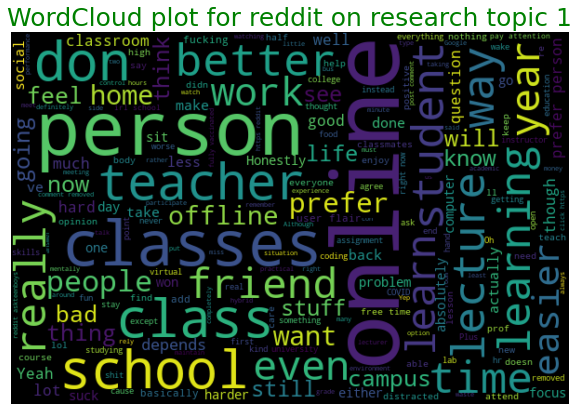

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Create wordcloud
all_words_reddit_1 = ' '.join([word for word in reddit_df_1['Cleaned Reviews']])
wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_reddit_1)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
# displaying the title
plt.title(label="WordCloud plot for reddit on research topic 1",
          fontsize=25,
          color="green")
plt.axis('off');

#### Topic 2

In [ ]:
# Cleaning the text in the Reddit_comments using helper function above
reddit_df_2['Cleaned Reviews'] = reddit_df_2['Comments'].apply(clean)
reddit_df_2.head()

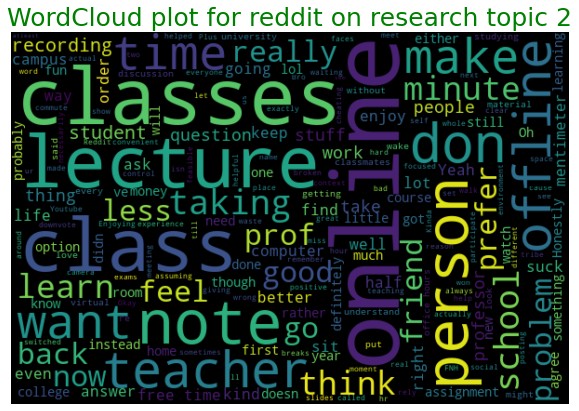

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Create wordcloud
all_words_reddit_2 = ' '.join([word for word in reddit_df_2['Cleaned Reviews']])
wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_reddit_2)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
# displaying the title
plt.title(label="WordCloud plot for reddit on research topic 2",
          fontsize=25,
          color="green")
plt.axis('off');

## Most common words across all comments on reddit
I implemented a plot showing the most common words used and we can see that this aligns with the word cloud above.

In [ ]:
# remove stop words
import nltk
from nltk.corpus import stopwords

# Make a list of english stopwords
stopword = nltk.corpus.stopwords.words("english")

# Extend the list with your own custom stopwords
my_stopwords = ['https','I']
stopword.extend(my_stopwords)

#### Reddit Topic 1

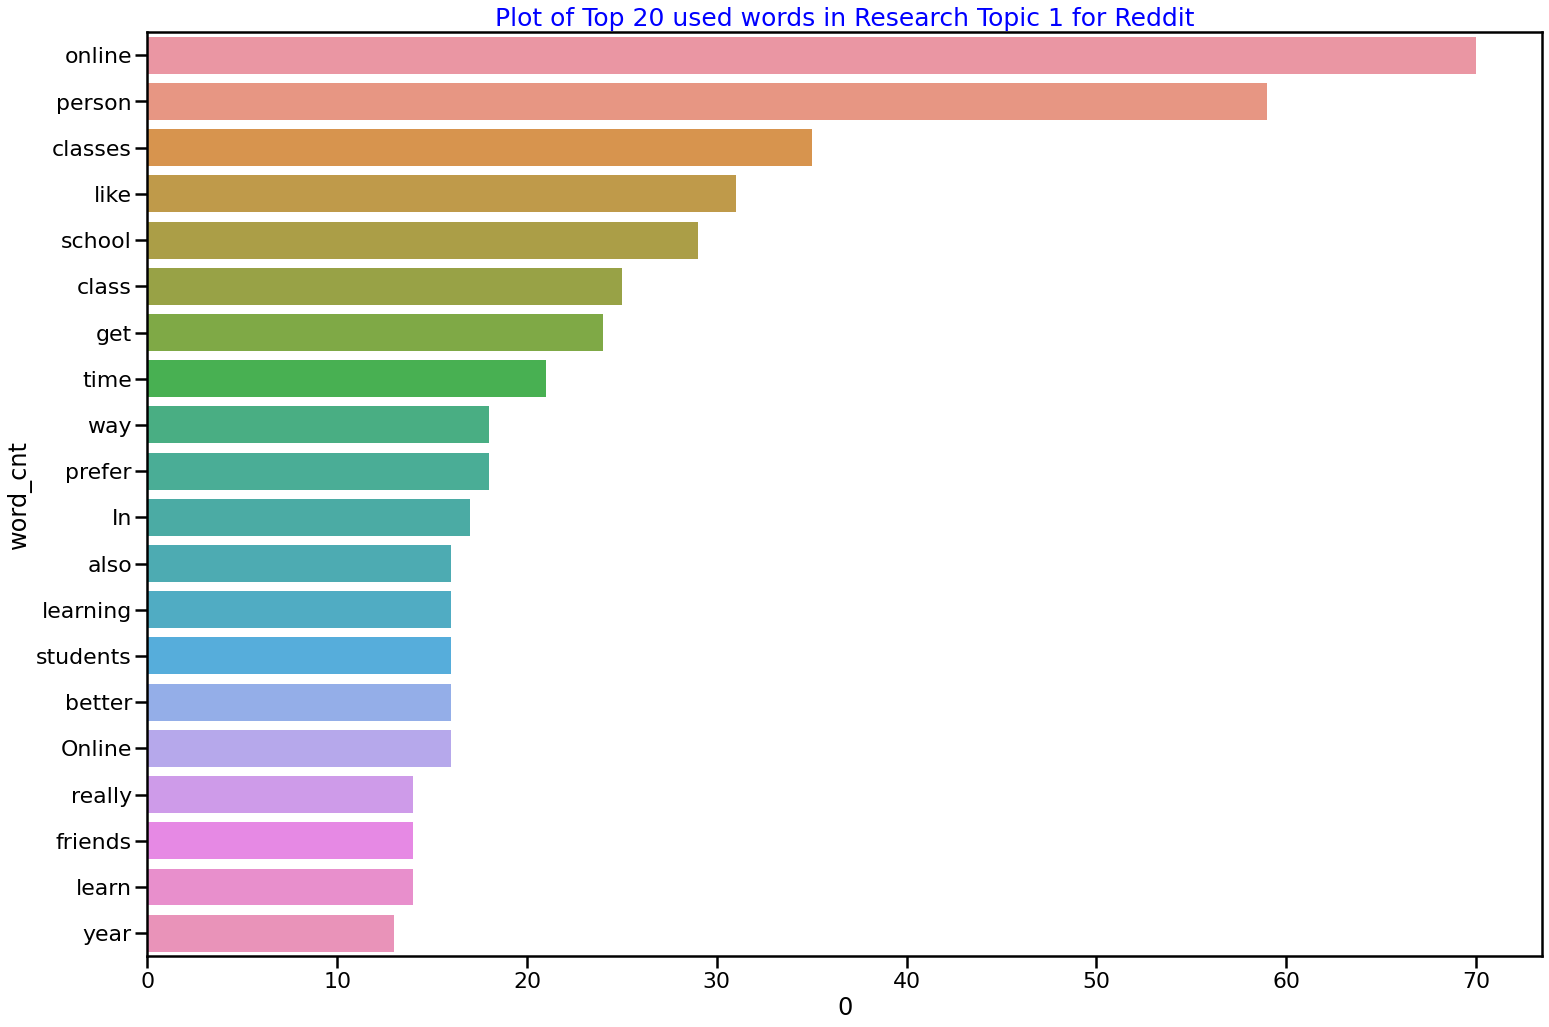

In [ ]:
tot_words_r_1 = pd.DataFrame (all_words_reddit_1.split(), columns = ['word_cnt'])
# remove stop words
tot_words_r_1 = tot_words_r_1.apply(lambda x: [item for item in x if item not in stopword]).value_counts()
# Convert back to pd
tot_words_r_1 = tot_words_r_1.reset_index()
# Get top 20
word_20_r_1 = tot_words_r_1.head(20)
plt.figure(figsize=(25,17))
plt.title(label="Plot of Top 20 used words in Research Topic 1 for Reddit",
          fontsize=25,
          color="Blue")
sns.barplot(x=0, y="word_cnt", data=word_20_r_1);

##### Reddit Topic 2

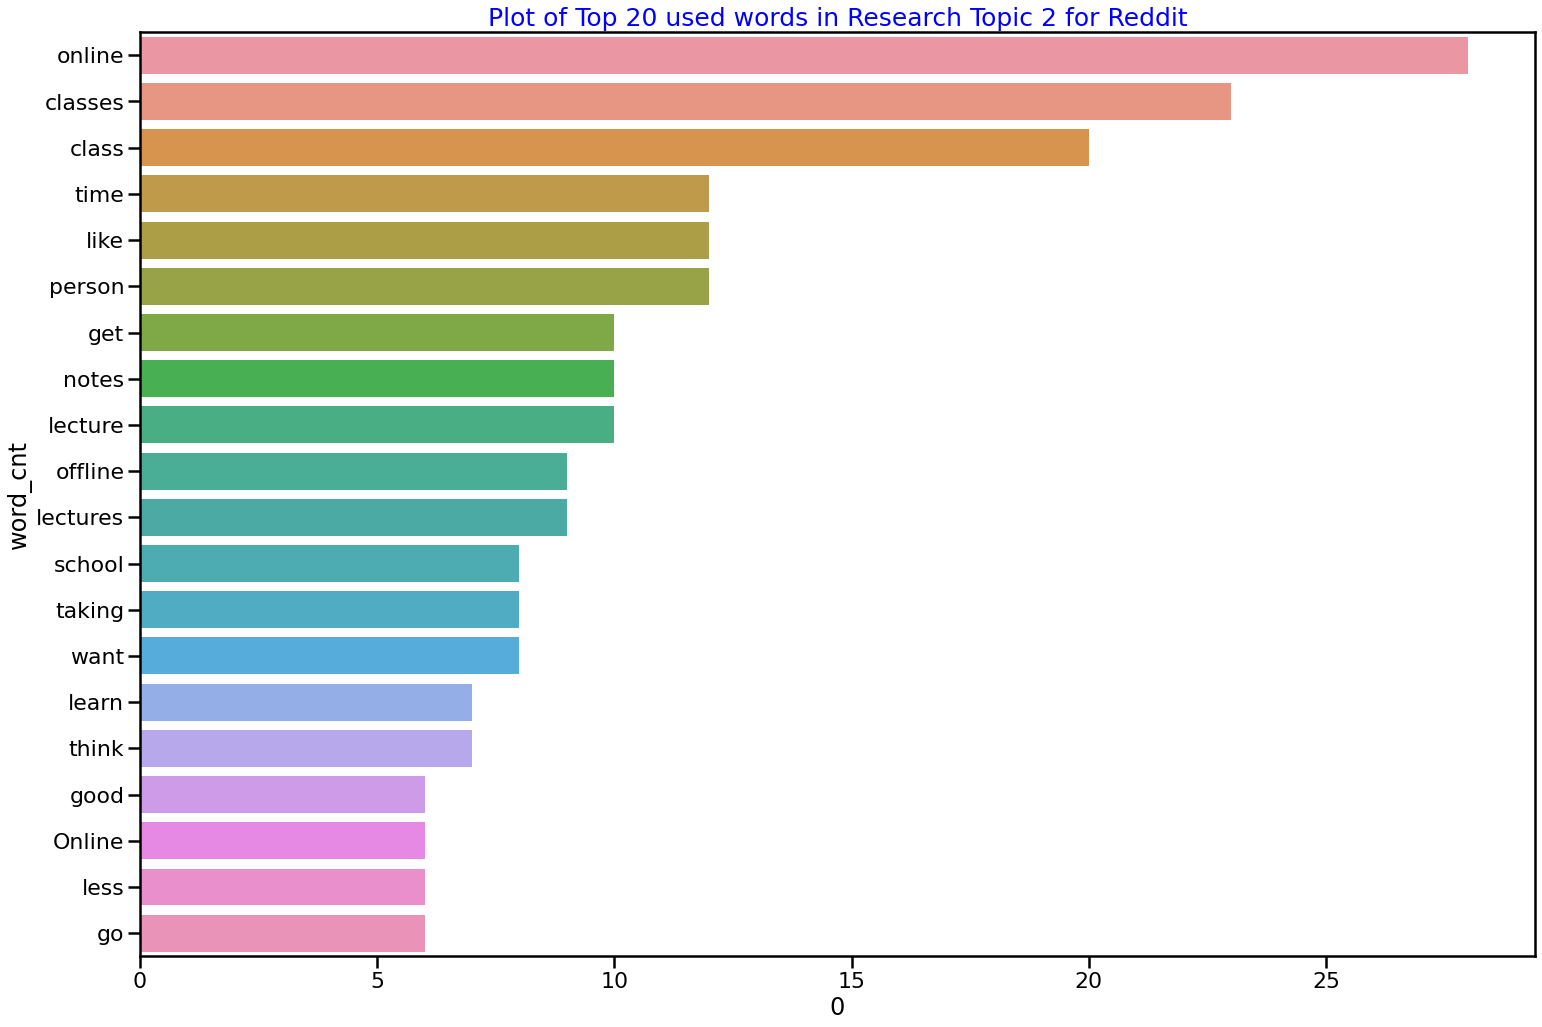

In [ ]:
tot_words_r_2 = pd.DataFrame (all_words_reddit_2.split(), columns = ['word_cnt'])
# remove stop words
tot_words_r_2 = tot_words_r_2.apply(lambda x: [item for item in x if item not in stopword]).value_counts()
# Convert back to pd
tot_words_r_2 = tot_words_r_2.reset_index()
# Get top 20
word_20_r_2 = tot_words_r_2.head(20)
plt.figure(figsize=(25,17))
plt.title(label="Plot of Top 20 used words in Research Topic 2 for Reddit",
          fontsize=25,
          color="Blue")
sns.barplot(x=0, y="word_cnt", data=word_20_r_2);

## Enrichment – Tokenization and POS tagging

I created a new column called Pos tagged which was gotten from the Cleaned reviews column by implementing the token_stop_pos function created above. 

#### Topic 1

In [ ]:
# Tokenizing the comments and using POS tagging
reddit_df_1['POS tagged'] = reddit_df_1['Cleaned Reviews'].apply(token_stop_pos)

#### Topic 2

In [ ]:
# Tokenizing the comments and using POS tagging
reddit_df_2['POS tagged'] = reddit_df_2['Cleaned Reviews'].apply(token_stop_pos)

## Stop word and Lemmization

I created a new column called Lemma which was gotten by applying the lemmatize function implemented above.

#### Topic 1

In [ ]:
# Lemmatization
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

wordnet_lem = WordNetLemmatizer()

reddit_df_1['Lemma'] = reddit_df_1['Cleaned Reviews'].apply(wordnet_lem.lemmatize)

#### Topic 2

In [ ]:
# Get the stem words
reddit_df_2['Lemma'] = reddit_df_2['Cleaned Reviews'].apply(wordnet_lem.lemmatize)

## Sentiment Analysis
FInally I added 6 new columns, 2 each for the 3 sentiment approaches used. 
- Textblob Analysis: Showing the textblob sentiment for each comment.
- Vader Analysis: Showing the Vader sentiment for each comment.
- SWN Analysis: Showing the sentiwordnet sentiment for each comment.

#### Topic 1

In [ ]:
# using TextBlob:
Reddit_final_data_1 = pd.DataFrame(reddit_df_1[['Comments', 'Lemma']])
# Reddit_final_data['Subjectivity'] = Reddit_final_data['Lemma'].apply(getSubjectivity) 
Reddit_final_data_1['Polarity'] = Reddit_final_data_1['Lemma'].apply(getPolarity) 
Reddit_final_data_1['Textblob Analysis'] = Reddit_final_data_1['Polarity'].apply(analysis)

In [ ]:
# using Vader:
Reddit_final_data_1['Vader Sentiment'] = Reddit_final_data_1['Lemma'].apply(vadersentimentanalysis)
Reddit_final_data_1['Vader Analysis'] = Reddit_final_data_1['Vader Sentiment'].apply(vader_analysis)

In [ ]:
# Using SentiWordNet
Reddit_final_data_1['SWN analysis'] = reddit_df_1['POS tagged'].apply(sentiwordnetanalysis)
Reddit_final_data_1.head()

,Comments,Lemma,Polarity,Textblob Analysis,Vader Sentiment,Vader Analysis,SWN analysis
0,Online for atleast 1 sem or almost 2 coz of good grades,Online for atleast sem or almost coz of good grades,0.700000,Positive,0.3892,Neutral,Neutral
1,"Online, cause I’m an introvert with severe IBS, online classes has been nothing but a blessing in disguise for me",Online cause I m an introvert with severe IBS online classes has been nothing but a blessing in disguise for me,0.000000,Neutral,-0.7745,Negative,Neutral
2,"I have offline classes. Though you get to explore and make friends it's really tiring. After 7 hrs of college I get back to my room wash clothes dry them, grab evening snacks do assignment, life is easier at home",I have offline classes Though you get to explore and make friends it s really tiring After hrs of college I get back to my room wash clothes dry them grab evening snacks do assignment life is easier at home,0.044444,Positive,0.6597,Positive,Neutral
3,"Yaar you can never compare them. If it was just studies and exams, online can match offline.\n\nBut college life is something way more. You meet people, you gain experience, random fun things happen.\n\nPlus the routine to get out of bed, get ready, and do stuff at college is way more enriching for life. Online me kahan yeh sab.",Yaar you can never compare them If it was just studies and exams online can match offline But college life is something way more You meet people you gain experience random fun things happen Plus the routine to get out of bed get ready and do stuff at college is way more enriching for life Online me kahan yeh sab,0.200000,Positive,0.9194,Positive,Negative
4,We've shifted to online for the first time until Jan 31. It sucks,We ve shifted to online for the first time until Jan It sucks,-0.025000,Negative,-0.3612,Neutral,Neutral


#### Topic 2

In [ ]:
# using TextBlob:
Reddit_final_data_2 = pd.DataFrame(reddit_df_2[['Comments', 'Lemma']])
# Reddit_final_data['Subjectivity'] = Reddit_final_data['Lemma'].apply(getSubjectivity) 
Reddit_final_data_2['Polarity'] = Reddit_final_data_2['Lemma'].apply(getPolarity) 
Reddit_final_data_2['Textblob Analysis'] = Reddit_final_data_2['Polarity'].apply(analysis)

In [ ]:
# using Vader:
Reddit_final_data_2['Vader Sentiment'] = Reddit_final_data_2['Lemma'].apply(vadersentimentanalysis)
Reddit_final_data_2['Vader Analysis'] = Reddit_final_data_2['Vader Sentiment'].apply(vader_analysis)

In [ ]:
# Using SentiWordNet
Reddit_final_data_2['SWN analysis'] = reddit_df_2['POS tagged'].apply(sentiwordnetanalysis)
Reddit_final_data_2.head()

,Comments,Lemma,Polarity,Textblob Analysis,Vader Sentiment,Vader Analysis,SWN analysis
0,Online for atleast 1 sem or almost 2 coz of good grades,Online for atleast sem or almost coz of good grades,0.700000,Positive,0.3892,Neutral,Neutral
1,"Online, cause I’m an introvert with severe IBS, online classes has been nothing but a blessing in disguise for me",Online cause I m an introvert with severe IBS online classes has been nothing but a blessing in disguise for me,0.000000,Neutral,-0.7745,Negative,Neutral
2,"I have offline classes. Though you get to explore and make friends it's really tiring. After 7 hrs of college I get back to my room wash clothes dry them, grab evening snacks do assignment, life is easier at home",I have offline classes Though you get to explore and make friends it s really tiring After hrs of college I get back to my room wash clothes dry them grab evening snacks do assignment life is easier at home,0.044444,Positive,0.6597,Positive,Neutral
3,"Yaar you can never compare them. If it was just studies and exams, online can match offline.\n\nBut college life is something way more. You meet people, you gain experience, random fun things happen.\n\nPlus the routine to get out of bed, get ready, and do stuff at college is way more enriching for life. Online me kahan yeh sab.",Yaar you can never compare them If it was just studies and exams online can match offline But college life is something way more You meet people you gain experience random fun things happen Plus the routine to get out of bed get ready and do stuff at college is way more enriching for life Online me kahan yeh sab,0.200000,Positive,0.9194,Positive,Negative
4,We've shifted to online for the first time until Jan 31. It sucks,We ve shifted to online for the first time until Jan It sucks,-0.025000,Negative,-0.3612,Neutral,Neutral


## Count the number of positive, negative, neutral reviews.
The sentiment count for each of the different sentiment analysis method used was now clear.

#### Topic 1

In [ ]:
# Count the number of positive, negative, neutral reviews Textblob.
reddit_tb_counts_1 = Reddit_final_data_1['Textblob Analysis'].value_counts()
# Count the number of positive, negative, neutral reviews SentiWord.
reddit_swn_counts_1= Reddit_final_data_1['SWN analysis'].value_counts()
# Count the number of positive, negative, neutral reviews Vader.
reddit_vader_counts_1 = Reddit_final_data_1['Vader Analysis'].value_counts()

In [ ]:
# count of sentiment class for reddit textblob analysis
reddit_tb_counts_1

Positive    84
Neutral     50
Negative    32
Name: Textblob Analysis, dtype: int64

In [ ]:
# count of sentiment class for reddit sentiwordnet analysis
reddit_swn_counts_1

Neutral     96
Positive    50
Negative    11
Name: SWN analysis, dtype: int64

In [ ]:
# count of sentiment class for reddit vader analysis
reddit_vader_counts_1

Neutral     104
Positive     44
Negative     18
Name: Vader Analysis, dtype: int64

#### Topic 2

In [ ]:
# Count the number of positive, negative, neutral reviews Textblob.
reddit_tb_counts_2 = Reddit_final_data_2['Textblob Analysis'].value_counts()
# Count the number of positive, negative, neutral reviews SentiWord.
reddit_swn_counts_2= Reddit_final_data_2['SWN analysis'].value_counts()
# Count the number of positive, negative, neutral reviews Vader.
reddit_vader_counts_2 = Reddit_final_data_2['Vader Analysis'].value_counts()

In [ ]:
# count of sentiment class for reddit textblob analysis
reddit_tb_counts_2

Positive    49
Neutral     24
Negative     7
Name: Textblob Analysis, dtype: int64

In [ ]:
# count of sentiment class for reddit sentiwordnet analysis
reddit_swn_counts_2

Neutral     42
Positive    26
Negative     7
Name: SWN analysis, dtype: int64

In [ ]:
# count of sentiment class for reddit vader analysis
reddit_vader_counts_2

Neutral     48
Positive    26
Negative     6
Name: Vader Analysis, dtype: int64

## Plot of sentiment
I then created a pie chart showing the different sentiment class for each of the three sentiment analysis approaches used

Topic 1

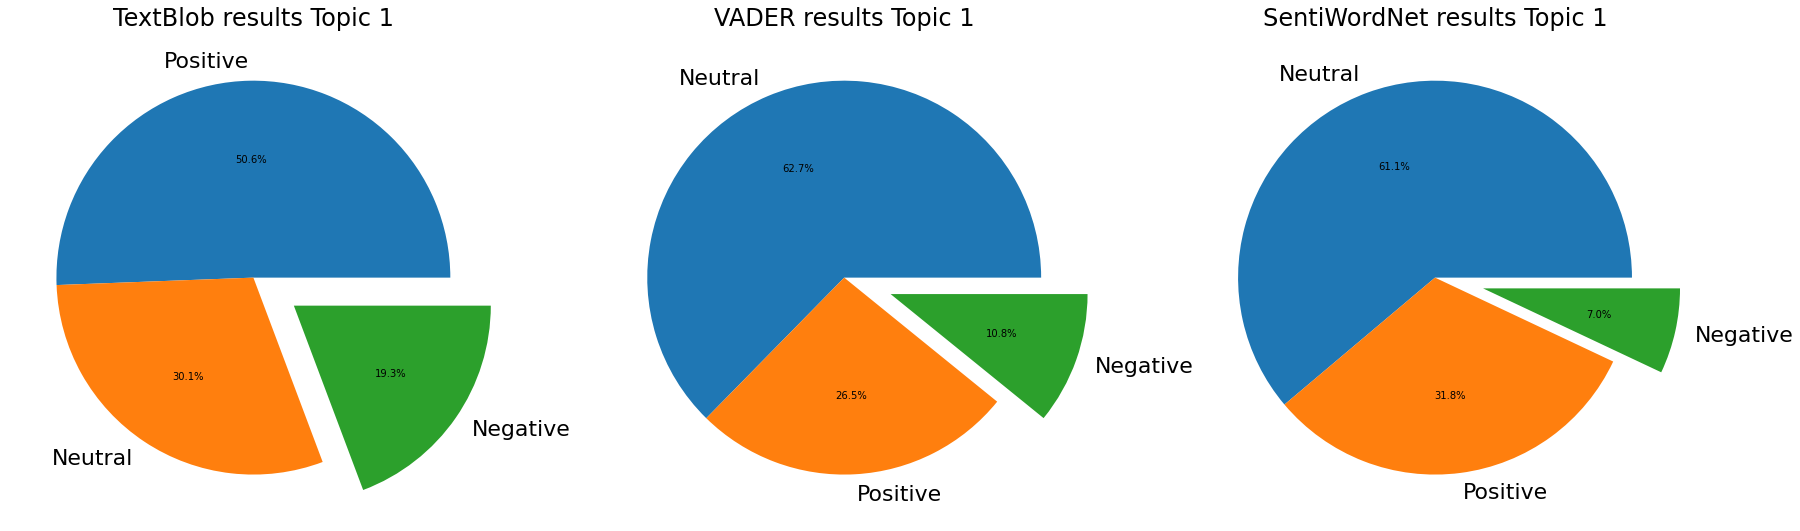

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(30,17))
plt.subplot(1,3,1)
plt.title("TextBlob results Topic 1")
plt.pie(reddit_tb_counts_1.values, labels = reddit_tb_counts_1.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER results Topic 1")
plt.pie(reddit_vader_counts_1.values, labels = reddit_vader_counts_1.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,3)
plt.title("SentiWordNet results Topic 1")
plt.pie(reddit_swn_counts_1.values, labels = reddit_swn_counts_1.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False);

#### Topic 2

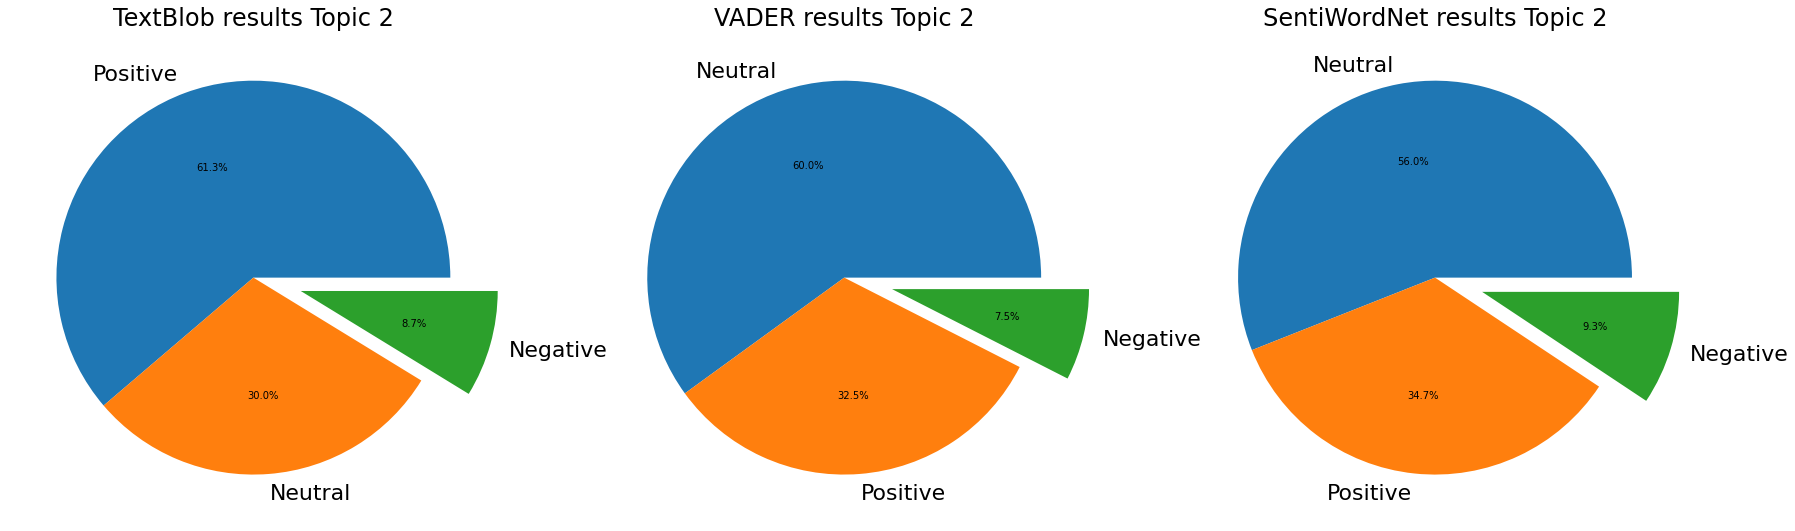

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(30,17))
plt.subplot(1,3,1)
plt.title("TextBlob results Topic 2")
plt.pie(reddit_tb_counts_2.values, labels = reddit_tb_counts_2.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER results Topic 2")
plt.pie(reddit_vader_counts_2.values, labels = reddit_vader_counts_2.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,3)
plt.title("SentiWordNet results Topic 2")
plt.pie(reddit_swn_counts_2.values, labels = reddit_swn_counts_2.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False);

# Quora Data extraction 
Here I extracted quora data using beautiful soup and selenium. I selected the css class that contains the answers, extracted the text and then passed them into a pandas dataframe

In [ ]:
# set options to be headless, ..
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
# open it, go to a website, and get results
wd = webdriver.Chrome(options=options)

#### Topic 1

In [ ]:

# Quora URLS
urls_1 = ['https://www.quora.com/Which-is-the-better-way-to-learn-online-training-or-classroom-training-Why',
      'https://www.quora.com/Do-you-prefer-online-classes',
      'https://www.quora.com/Which-is-better-classroom-or-online-teaching',
      'https://www.quora.com/What-do-you-think-about-online-learning-compared-with-face-to-face-learning-Is-it-better-worse-the-same',
      'https://www.quora.com/What-is-your-opinion-on-face-to-face-classes-in-the-time-of-a-pandemic',
      'https://www.quora.com/How-desirable-is-an-online-education-over-traditional-education']
df_1 = pd.DataFrame({"question": [],"answers":[]})

for URL in urls_1:
    wd.get(URL)
    PAUSE_TIME = 2

    lh = wd.execute_script("return document.body.scrollHeight")

    while True:

        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(PAUSE_TIME)
        nh = wd.execute_script("return document.body.scrollHeight")
        if nh == lh:
            break
        lh = nh
    soup=BeautifulSoup(wd.page_source, 'html.parser')
    question = soup.find('title')
    question =  question.text.replace(" - Quora","")
    answers = soup.find_all('div', attrs={'class': "q-box spacing_log_answer_content puppeteer_test_answer_content"})
    for answer in answers:
     df_1 = df_1.append({'question': question,
         'answers': answer.text
          }, ignore_index=True)


quora_df_1 = df_1.copy()

#### Topic 2

In [ ]:

# Quora URLS
urls_2 = ['https://www.quora.com/Which-is-the-better-way-to-learn-online-training-or-classroom-training-Why',
      'https://www.quora.com/What-do-you-think-about-online-learning-compared-with-face-to-face-learning-Is-it-better-worse-the-same',
      'https://www.quora.com/What-is-your-opinion-on-face-to-face-classes-in-the-time-of-a-pandemic',
      'https://www.quora.com/Can-e-learning-replace-live-classroom-education-How-and-why',
      'https://www.quora.com/How-desirable-is-an-online-education-over-traditional-education',
      'https://www.quora.com/How-much-online-education-is-different-from-offline-college-Which-is-the-best-way-to-learn-offline-or-online',
      'https://www.quora.com/What-are-the-benefits-of-online-learning-in-2020']
df_2 = pd.DataFrame({"question": [],"answers":[]})

for URL in urls_2:
    wd.get(URL)
    PAUSE_TIME = 2

    lh = wd.execute_script("return document.body.scrollHeight")

    while True:

        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(PAUSE_TIME)
        nh = wd.execute_script("return document.body.scrollHeight")
        if nh == lh:
            break
        lh = nh
    soup=BeautifulSoup(wd.page_source, 'html.parser')
    question = soup.find('title')
    question =  question.text.replace(" - Quora","")
    answers = soup.find_all('div', attrs={'class': "q-box spacing_log_answer_content puppeteer_test_answer_content"})
    for answer in answers:
     df_2 = df_2.append({'question': question,
         'answers': answer.text
          }, ignore_index=True)


quora_df_2 = df_2.copy()

# Quora sentiment 
In this section I implemented the Quora aspect of our sentiment analysis.

## Cleaning the text
I cleaned the text using the clean function created above, this removed all unwanted
chracters. I then created a new column called cleaned reviews which holds our cleaned text.

#### Topic 1

In [ ]:
# Cleaning the text in the Reddit_comments using helper function above
quora_df_1['Cleaned Reviews'] = quora_df_1['answers'].apply(clean)

#### Topic 2

In [ ]:
# Cleaning the text in the Reddit_comments using helper function above
quora_df_2['Cleaned Reviews'] = quora_df_2['answers'].apply(clean)

## WordCloud
I implemented a word cloud for the quora data also as seen below

#### Topic 1

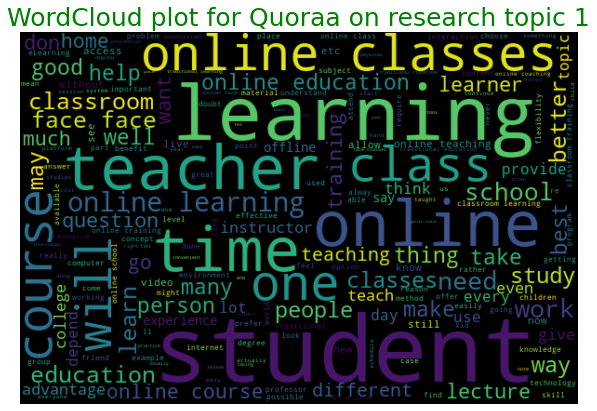

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Create wordcloud
all_words_quora_1 = ' '.join([word for word in quora_df_1['Cleaned Reviews']])
wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_quora_1)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(label="WordCloud plot for Quoraa on research topic 1",
          fontsize=25,
          color="green")
plt.axis('off');

#### Topic 2

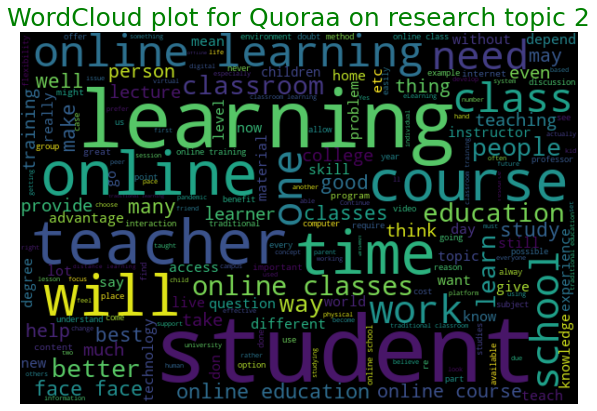

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Create wordcloud
all_words_quora_2 = ' '.join([word for word in quora_df_2['Cleaned Reviews']])
wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_quora_2)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(label="WordCloud plot for Quoraa on research topic 2",
          fontsize=25,
          color="green")
plt.axis('off');

## Most common words across all comments on reddit
I implemented a plot showing the most common words used and we can see that this also aligns
with the word cloud above.

#### Topic 1

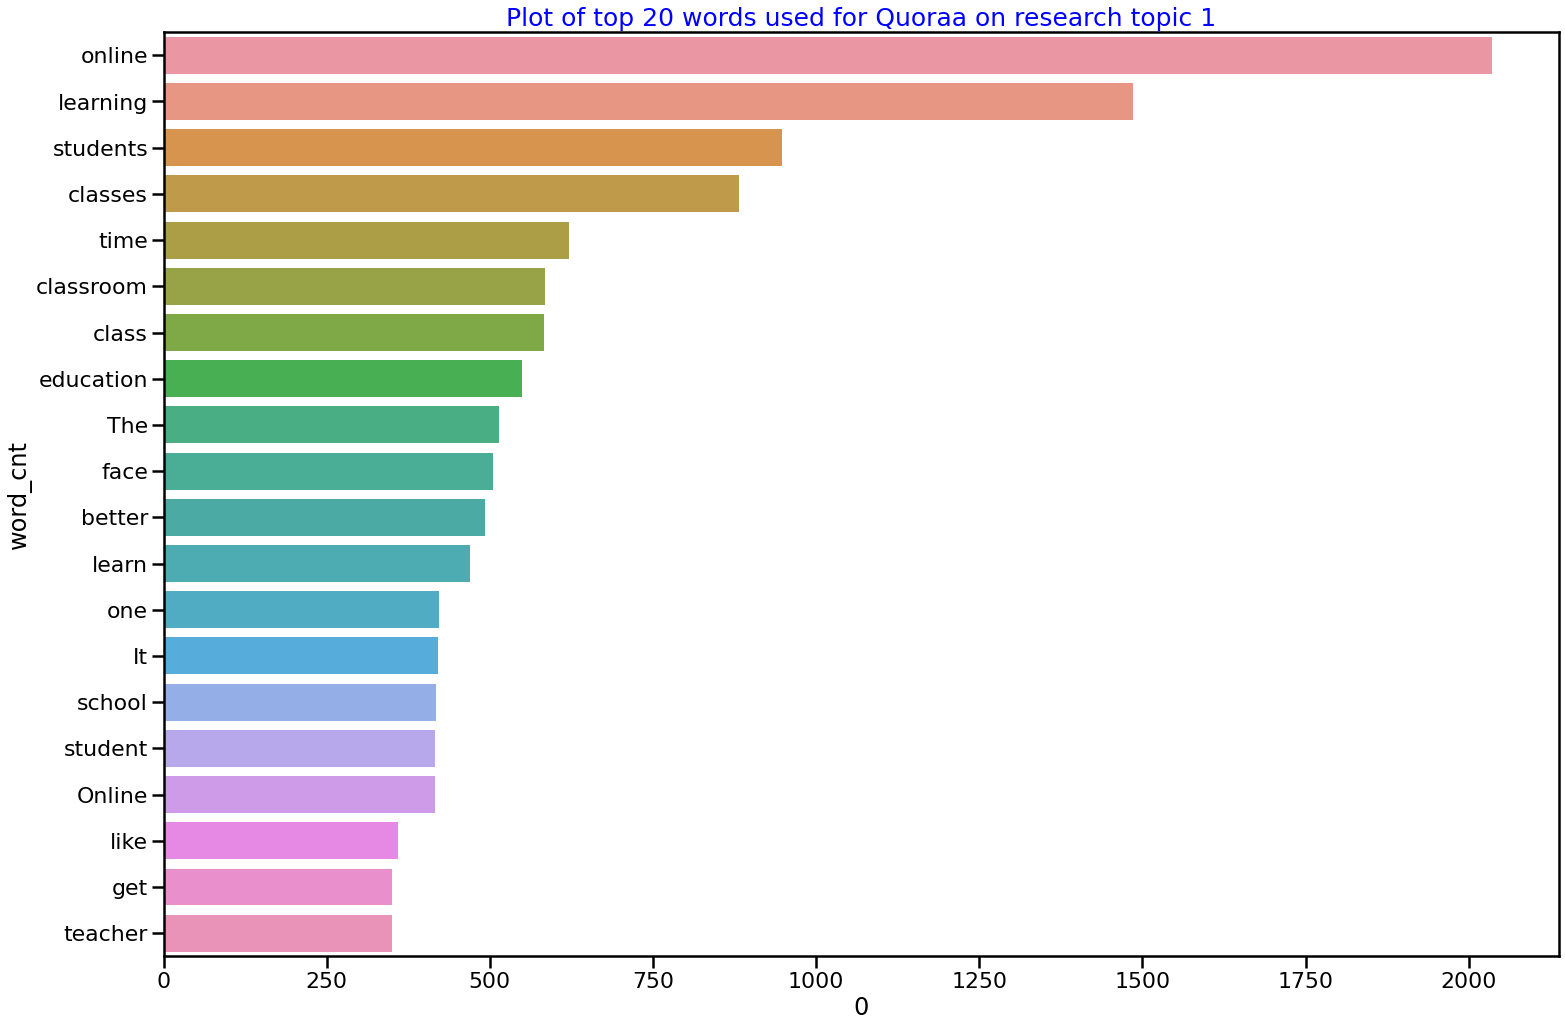

In [ ]:
tot_words_q_1 = pd.DataFrame (all_words_quora_1.split(), columns = ['word_cnt'])
# remove stop words using function above
tot_words_q_1 = tot_words_q_1.apply(lambda x: [item for item in x if item not in stopword]).value_counts()
# Convert back to pd
tot_words_q_1 = tot_words_q_1.reset_index()
# Get top 20
word_20_q_1 = tot_words_q_1.head(20)
plt.figure(figsize=(25,17))
plt.title(label="Plot of top 20 words used for Quoraa on research topic 1",
          fontsize=25,
          color="blue")
sns.barplot(x=0, y="word_cnt", data=word_20_q_1)

#### Topic 2

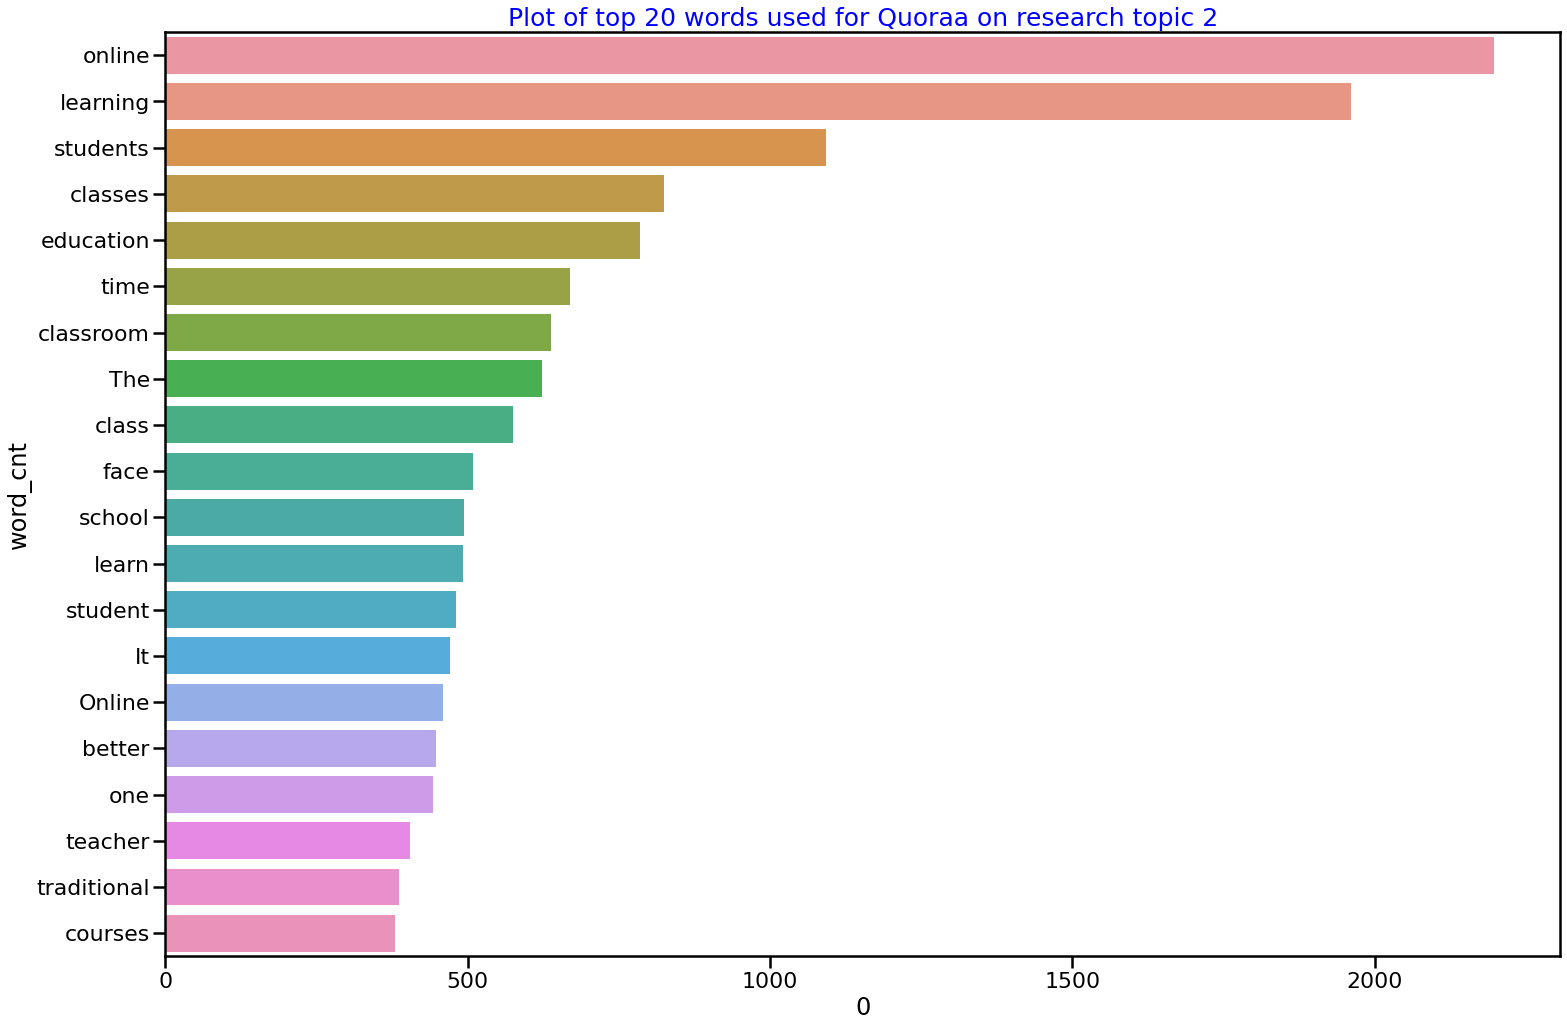

In [ ]:
tot_words_q_2 = pd.DataFrame (all_words_quora_2.split(), columns = ['word_cnt'])
# remove stop words using function above
tot_words_q_2 = tot_words_q_2.apply(lambda x: [item for item in x if item not in stopword]).value_counts()
# Convert back to pd
tot_words_q_2 = tot_words_q_2.reset_index()
# Get top 20
word_20_q_2 = tot_words_q_2.head(20)
plt.figure(figsize=(25,17))
plt.title(label="Plot of top 20 words used for Quoraa on research topic 2",
          fontsize=25,
          color="blue")
sns.barplot(x=0, y="word_cnt", data=word_20_q_2)

## Enrichment – Tokenization and POS tagging
I then created a new column called Pos tagged which was gotten from the cleaned reviews
column by implementing the token_stop_pos function created above.

#### Topic 1

In [ ]:
# Tokenizing the comments and using POS tagging
quora_df_1['POS tagged'] = quora_df_1['Cleaned Reviews'].apply(token_stop_pos)

#### Topc 2

In [ ]:
# Tokenizing the comments and using POS tagging
quora_df_2['POS tagged'] = quora_df_2['Cleaned Reviews'].apply(token_stop_pos)

## Stop word and Lemmization
I created a new column called Lemma which was gotten by applying the lemmatize function
implemented above. In this scenario I did not make use of the POS tagged because it gave null words. I used the WordNetLemmatizer gotten from NLTK which  offers an interface to it, but you have to download it first in order to use it which was done as below.

#### Topic 1

In [ ]:
# Lemmatization
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

wordnet_lem = WordNetLemmatizer()

quora_df_1['Lemma'] = quora_df_1['Cleaned Reviews'].apply(wordnet_lem.lemmatize)

#### Topic 2

In [ ]:
# Lemmatization
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

wordnet_lem = WordNetLemmatizer()

quora_df_2['Lemma'] = quora_df_2['Cleaned Reviews'].apply(wordnet_lem.lemmatize)

## Sentiment Analysis
FInally I added 6 new columns, 2 each for the 3 sentiment approaches used.
- Textblob Analysis: SHowing the textblob sentiment for each comment.
- Vader Analysis: SHowing the Vader sentiment for each comment.
- SWN Analysis: SHowing the sentiwordnet sentiment for each comment.

#### Topic 1

In [ ]:
# using TextBlob:
quora_final_data_1 = pd.DataFrame(quora_df_1[['answers', 'Lemma']])
# Reddit_final_data['Subjectivity'] = Reddit_final_data['Lemma'].apply(getSubjectivity) 
quora_final_data_1['Polarity'] = quora_final_data_1['Lemma'].apply(getPolarity) 
quora_final_data_1['Textblob Analysis'] = quora_final_data_1['Polarity'].apply(analysis)

In [ ]:
# using Vader:
quora_final_data_1['Vader Sentiment'] = quora_final_data_1['Lemma'].apply(vadersentimentanalysis)
quora_final_data_1['Vader Analysis'] = quora_final_data_1['Vader Sentiment'].apply(vader_analysis)

In [ ]:
# Using SentiWordNet
quora_final_data_1['SWN analysis'] = quora_df_1['POS tagged'].apply(sentiwordnetanalysis)
quora_final_data_1.head()

,answers,Lemma,Polarity,Textblob Analysis,Vader Sentiment,Vader Analysis,SWN analysis
0,"In my opinion if a teacher uses the technology intelligently, online classes can be more effective as compared to the traditional classes. Look in the traditional classes, we can explain well but that we can do in the online classes too but here the teacher can be imaginative and find so many videos/animations/presentations/activities, etc to make the children infer the result themselves, making learning fun and more productive and long time.",In my opinion if a teacher uses the technology intelligently online classes can be more effective as compared to the traditional classes Look in the traditional classes we can explain well but that we can do in the online classes too but here the teacher can be imaginative and find so many videos animations presentations activities etc to make the children infer the result themselves making learning fun and more productive and long time,0.375000,Positive,0.8480,Positive,Negative
1,"Easy technological advancement apps facilitate great collaboration between the information source, medium, and the recipient. Numerous internet-based courses today depend intensely on online learning stages and management styles that permit joint effort among students and educators. Tools like online conversation sheets, one-on-one messaging, and email (of course) for examining ideas, and systems administration impact the education system on an extraordinary level. The best part is that a large portion of these tech apps is not difficult to use. Most can be downloaded as an application on a cellContinue ReadingEasy technological advancement apps facilitate great collaboration between the information source, medium, and the recipient. Numerous internet-based courses today depend intensely on online learning stages and management styles that permit joint effort among students and educators. Tools like online conversation sheets, one-on-one messaging, and email (of course) for examining ideas, and systems administration impact the education system on an extraordinary level. The best part is that a large portion of these tech apps is not difficult to use. Most can be downloaded as an application on a cell phone or potentially PC. So exploring through the course materials—regardless of whether they are live or recorded—is surprisingly convenient. So, can online classes be as effective as offline? Maybe. Perhaps the combination of online and offline studies would likely be more advantageous and yield higher development in a child’s education.",Easy technological advancement apps facilitate great collaboration between the information source medium and the recipient Numerous internet based courses today depend intensely on online learning stages and management styles that permit joint effort among students and educators Tools like online conversation sheets one on one messaging and email of course for examining ideas and systems administration impact the education system on an extraordinary level The best part is that a large portion of these tech apps is not difficult to use Most can be downloaded as an application on a cellContinue ReadingEasy technological advancement apps facilitate great collaboration between the information source medium and the recipient Numerous internet based courses today depend intensely on online learning stages and management styles that permit joint effort among students and educators Tools like online conversation sheets one on one messaging and email of course for examining ideas and systems administration impact the education system on an extraordinary level The best part is that a large portion of these tech apps is not difficult to use Most can be downloaded as an application on a cell phone or potentially PC So exploring through the course materials regardless of whether they are live or recorded is surprisingly convenient So can online classes be as effective as offline Maybe Perhaps the combi

#### Topic 2

In [ ]:
# using TextBlob:
quora_final_data_2 = pd.DataFrame(quora_df_2[['answers', 'Lemma']])
# Reddit_final_data['Subjectivity'] = Reddit_final_data['Lemma'].apply(getSubjectivity) 
quora_final_data_2['Polarity'] = quora_final_data_2['Lemma'].apply(getPolarity) 
quora_final_data_2['Textblob Analysis'] = quora_final_data_2['Polarity'].apply(analysis)

In [ ]:
# using Vader:
quora_final_data_2['Vader Sentiment'] = quora_final_data_2['Lemma'].apply(vadersentimentanalysis)
quora_final_data_2['Vader Analysis'] = quora_final_data_2['Vader Sentiment'].apply(vader_analysis)

In [ ]:
# Using SentiWordNet
quora_final_data_2['SWN analysis'] = quora_df_2['POS tagged'].apply(sentiwordnetanalysis)
quora_final_data_2.head()

,answers,Lemma,Polarity,Textblob Analysis,Vader Sentiment,Vader Analysis,SWN analysis
0,"In my opinion if a teacher uses the technology intelligently, online classes can be more effective as compared to the traditional classes. Look in the traditional classes, we can explain well but that we can do in the online classes too but here the teacher can be imaginative and find so many videos/animations/presentations/activities, etc to make the children infer the result themselves, making learning fun and more productive and long time.",In my opinion if a teacher uses the technology intelligently online classes can be more effective as compared to the traditional classes Look in the traditional classes we can explain well but that we can do in the online classes too but here the teacher can be imaginative and find so many videos animations presentations activities etc to make the children infer the result themselves making learning fun and more productive and long time,0.375000,Positive,0.8480,Positive,Negative
1,"Easy technological advancement apps facilitate great collaboration between the information source, medium, and the recipient. Numerous internet-based courses today depend intensely on online learning stages and management styles that permit joint effort among students and educators. Tools like online conversation sheets, one-on-one messaging, and email (of course) for examining ideas, and systems administration impact the education system on an extraordinary level. The best part is that a large portion of these tech apps is not difficult to use. Most can be downloaded as an application on a cellContinue ReadingEasy technological advancement apps facilitate great collaboration between the information source, medium, and the recipient. Numerous internet-based courses today depend intensely on online learning stages and management styles that permit joint effort among students and educators. Tools like online conversation sheets, one-on-one messaging, and email (of course) for examining ideas, and systems administration impact the education system on an extraordinary level. The best part is that a large portion of these tech apps is not difficult to use. Most can be downloaded as an application on a cell phone or potentially PC. So exploring through the course materials—regardless of whether they are live or recorded—is surprisingly convenient. So, can online classes be as effective as offline? Maybe. Perhaps the combination of online and offline studies would likely be more advantageous and yield higher development in a child’s education.",Easy technological advancement apps facilitate great collaboration between the information source medium and the recipient Numerous internet based courses today depend intensely on online learning stages and management styles that permit joint effort among students and educators Tools like online conversation sheets one on one messaging and email of course for examining ideas and systems administration impact the education system on an extraordinary level The best part is that a large portion of these tech apps is not difficult to use Most can be downloaded as an application on a cellContinue ReadingEasy technological advancement apps facilitate great collaboration between the information source medium and the recipient Numerous internet based courses today depend intensely on online learning stages and management styles that permit joint effort among students and educators Tools like online conversation sheets one on one messaging and email of course for examining ideas and systems administration impact the education system on an extraordinary level The best part is that a large portion of these tech apps is not difficult to use Most can be downloaded as an application on a cell phone or potentially PC So exploring through the course materials regardless of whether they are live or recorded is surprisingly convenient So can online classes be as effective as offline Maybe Perhaps the combi

## Count the number of positive, negative, neutral reviews.
I got the sentiment count for each of the different sentiment analysis methods used.

Topic 1

In [ ]:
# Count the number of positive, negative, neutral reviews Textblob.
quora_tb_counts_1 = quora_final_data_1['Textblob Analysis'].value_counts()
# Count the number of positive, negative, neutral reviews SentiWord.
quora_swn_counts_1 = quora_final_data_1['SWN analysis'].value_counts()
# Count the number of positive, negative, neutral reviews Vader.
quora_vader_counts_1 = quora_final_data_1['Vader Analysis'].value_counts()

In [ ]:
# count of sentiment class for quora textblob analysis
quora_tb_counts_1

Positive    624
Negative     52
Neutral      22
Name: Textblob Analysis, dtype: int64

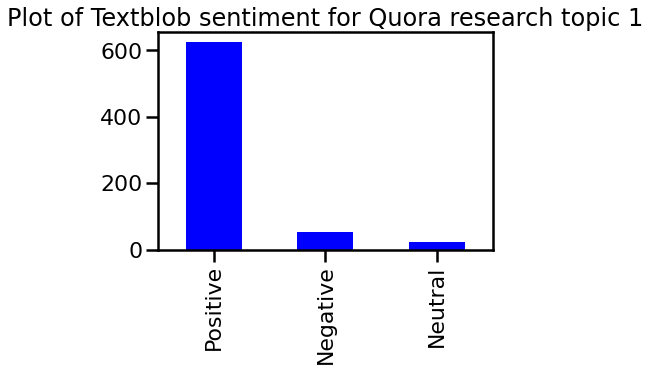

In [ ]:
quora_tb_counts_1.plot.bar(title='Plot of Textblob sentiment for Quora research topic 1', color="blue");

In [ ]:
# count of sentiment class for quora sentiwordnet  analysis
quora_swn_counts_1

Neutral     463
Positive    177
Negative     56
Name: SWN analysis, dtype: int64

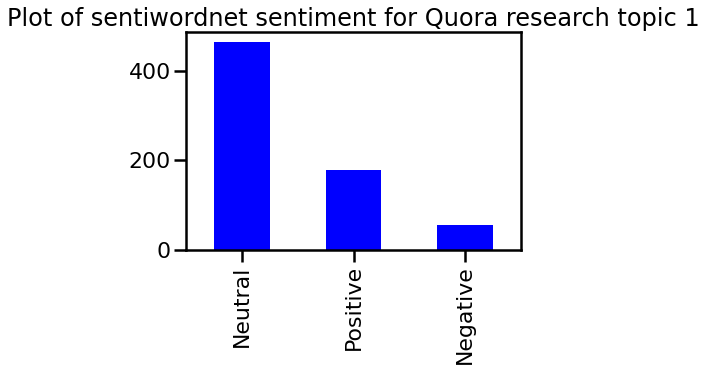

In [ ]:
quora_swn_counts_1.plot.bar(title='Plot of sentiwordnet sentiment for Quora research topic 1', color="blue");

In [ ]:
# count of sentiment class for quora vader analysis
quora_vader_counts_1

Positive    521
Neutral     142
Negative     35
Name: Vader Analysis, dtype: int64

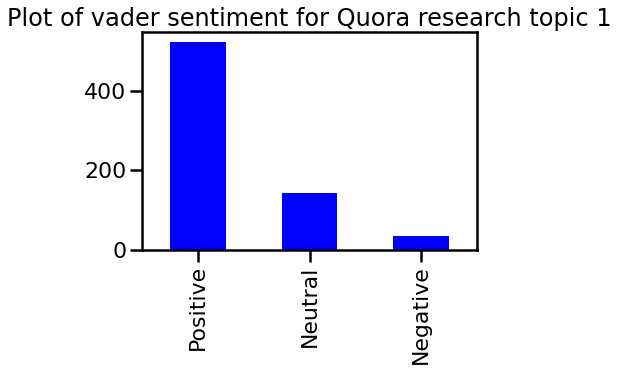

In [ ]:
quora_vader_counts_1.plot.bar(title='Plot of vader sentiment for Quora research topic 1', color="blue");

#### Topic 2

In [ ]:
# Count the number of positive, negative, neutral reviews Textblob.
quora_tb_counts_2 = quora_final_data_2['Textblob Analysis'].value_counts()
# Count the number of positive, negative, neutral reviews SentiWord.
quora_swn_counts_2 = quora_final_data_2['SWN analysis'].value_counts()
# Count the number of positive, negative, neutral reviews Vader.
quora_vader_counts_2 = quora_final_data_2['Vader Analysis'].value_counts()

In [ ]:
# count of sentiment class for quora textblob analysis
quora_tb_counts_2

Positive    691
Negative     55
Neutral      21
Name: Textblob Analysis, dtype: int64

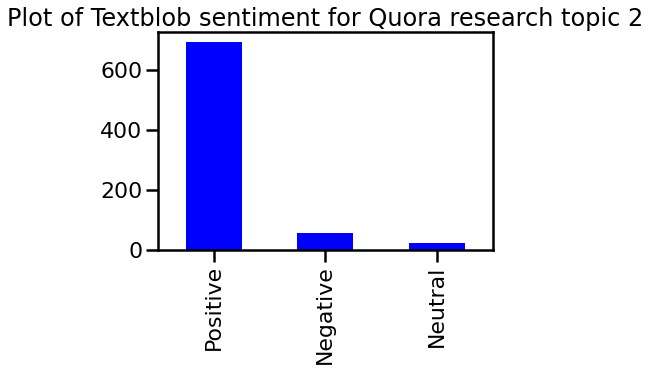

In [ ]:
quora_tb_counts_2.plot.bar(title='Plot of Textblob sentiment for Quora research topic 2', color="blue");

In [ ]:
# count of sentiment class for quora sentiwordnet  analysis
quora_swn_counts_2

Neutral     520
Positive    183
Negative     62
Name: SWN analysis, dtype: int64

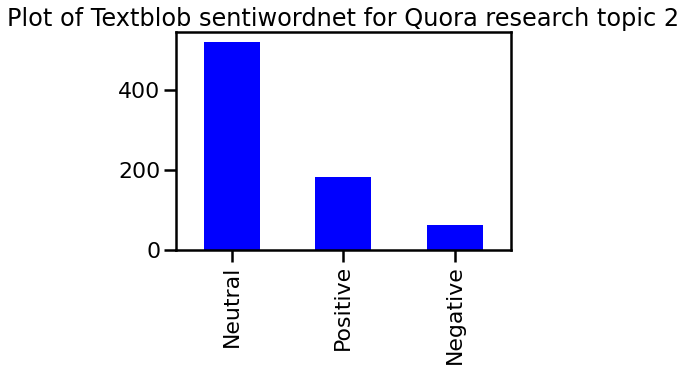

In [ ]:
quora_swn_counts_2.plot.bar(title='Plot of Textblob sentiwordnet for Quora research topic 2', color="blue");

In [ ]:
# count of sentiment class for quora vader analysis
quora_vader_counts_2

Positive    572
Neutral     156
Negative     39
Name: Vader Analysis, dtype: int64

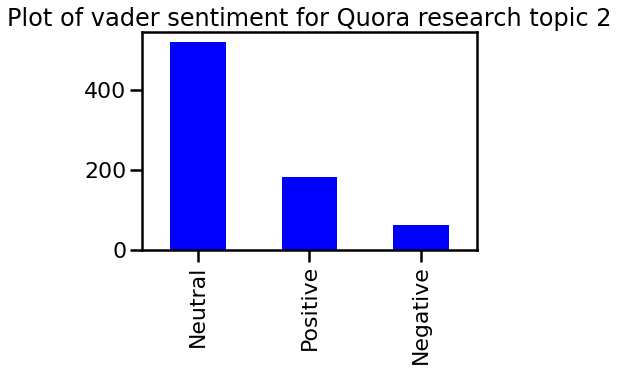

In [ ]:
quora_swn_counts_2.plot.bar(title='Plot of vader sentiment for Quora research topic 2', color="blue");

## Plot of sentiment
I then created a pie chart showing the different sentiment class for each of the three
sentiment analysis approaches used

#### Topic 1

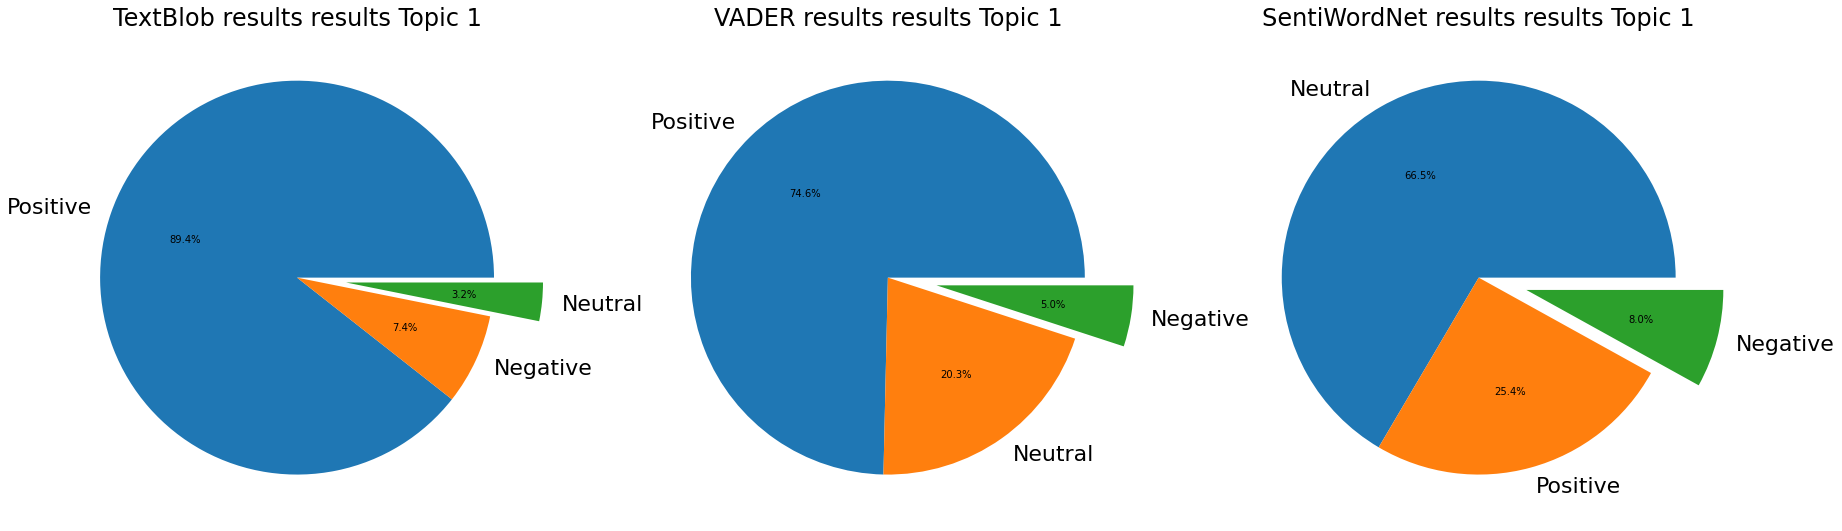

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(30,17))
plt.subplot(1,3,1)
plt.title("TextBlob results results Topic 1")
plt.pie(quora_tb_counts_1.values, labels = quora_tb_counts_1.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER results results Topic 1")
plt.pie(quora_vader_counts_1.values, labels = quora_vader_counts_1.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,3)
plt.title("SentiWordNet results results Topic 1")
plt.pie(quora_swn_counts_1.values, labels = quora_swn_counts_1.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False);

#### Topic 2

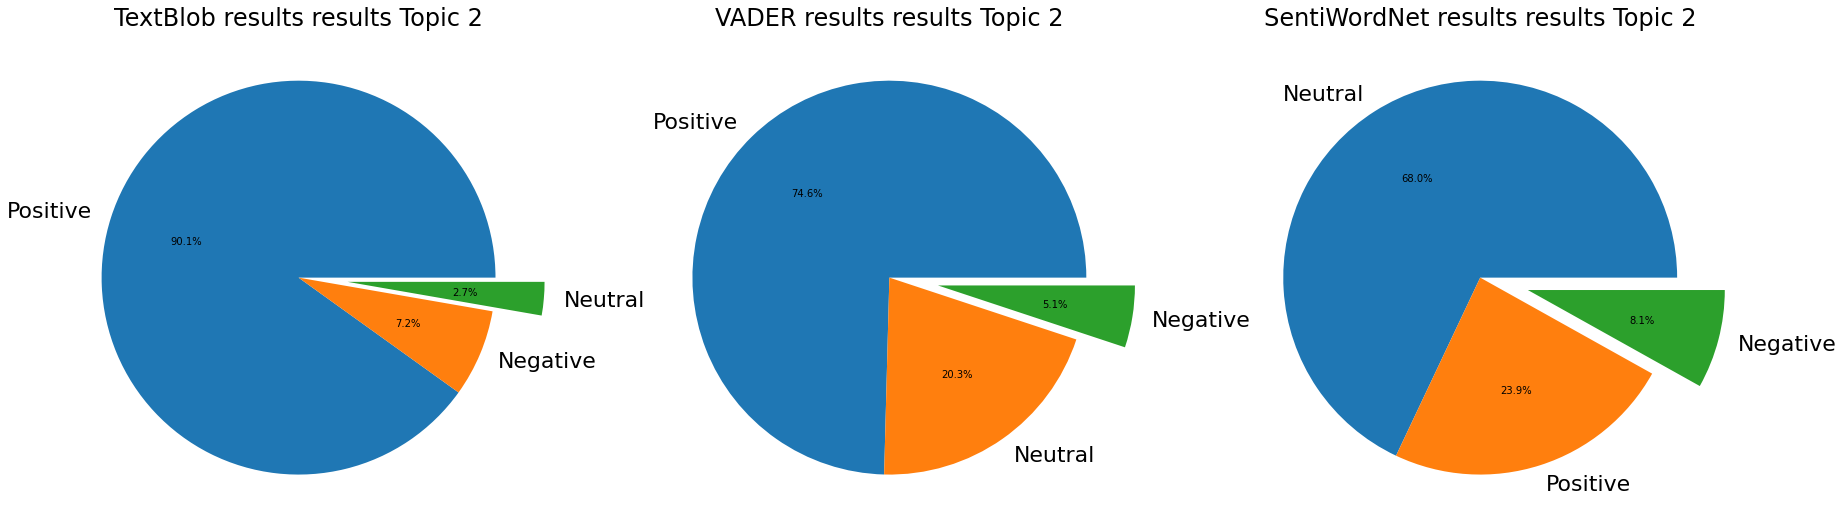

In [ ]:
%matplotlib inline
plt.figure(figsize=(30,17))
plt.subplot(1,3,1)
plt.title("TextBlob results results Topic 2")
plt.pie(quora_tb_counts_2.values, labels = quora_tb_counts_2.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER results results Topic 2")
plt.pie(quora_vader_counts_2.values, labels = quora_vader_counts_2.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,3)
plt.title("SentiWordNet results results Topic 2")
plt.pie(quora_swn_counts_2.values, labels = quora_swn_counts_2.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False);